In [1]:
import numpy as np
from itertools import chain
from numpy.lib.stride_tricks import as_strided
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Convolution using numpy #

In [2]:
def convolution_ver1(image: np.array, kernel: np.array, pad=0, stride=1):
    kernel_h, kernel_w = kernel.shape
    padded_image = np.pad(image, pad)
    padded_image_h, padded_image_w = padded_image.shape
    output = []
    
    for i in range(0, padded_image_h - kernel_h + 1, stride):
        for j in range(0, padded_image_w - kernel_w + 1, stride):
            output.append(np.sum(padded_image[i:i+kernel_w, j:j+kernel_h] * kernel))
            
    output_h, output_w = (padded_image_h - kernel_h) // stride + 1, (padded_image_w - kernel_w) // stride + 1
                       
    return np.array(output).reshape(output_h, output_w)

In [3]:
def convolution_ver2(image: np.array, kernel: np.array, pad=0, stride=1):
    padded_image = np.pad(image, pad)
    padded_image_h, padded_image_w = padded_image.shape
    kernel_h, kernel_w = kernel.shape

    out_shape = ((padded_image_h - kernel_h) // stride + 1, (padded_image_w - kernel_w) // stride + 1, kernel_h, kernel_w)
    out_strides = (padded_image.strides[0] * stride, padded_image.strides[1] * stride, padded_image.strides[0], padded_image.strides[1])
    windows = as_strided(padded_image, shape=out_shape, strides=out_strides)

    return np.tensordot(windows, kernel)

In [4]:
image=np.random.randint(1, 10, size=(7,7))
#img = np.array([[45, 63, 27, 90, 34], [36, 18, 81, 9, 87], [9, 54, 72, 99, 56], [83, 23, 12, 43, 54], [27, 8, 19, 67, 69]])
kernel=np.ones((4,4))
print("Input 'image'\n", image)
print("Kernel\n", kernel)

Input 'image'
 [[6 1 1 2 5 8 2]
 [4 9 3 9 5 6 1]
 [6 5 6 5 8 5 5]
 [8 7 1 5 5 7 4]
 [5 6 9 3 6 5 3]
 [7 9 3 5 6 7 9]
 [3 6 3 3 1 5 6]]
Kernel
 [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [5]:
convolution_ver1(image, kernel, pad=0, stride=3)

array([[78., 82.],
       [83., 80.]])

In [6]:
convolution_ver2(image, kernel, pad=0, stride=3)

array([[78., 82.],
       [83., 80.]])

# Working with an image #

## Reading an image ##

(654, 685, 3)


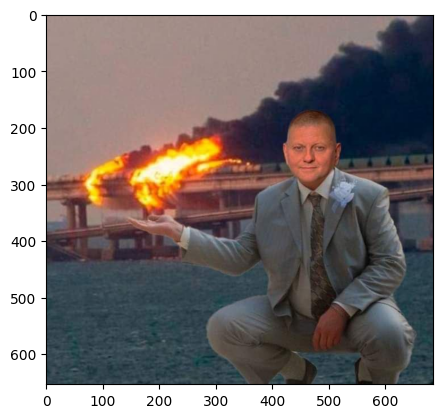

In [7]:
img_brg = cv2.imread('image.jpg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_brg, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
plt.imshow(img_rgb)

## Converting to tensor ##

In [8]:
img_tf = tf.convert_to_tensor(img_rgb, dtype=tf.float32)
print(img_tf.shape)

(654, 685, 3)


## Applying filters ##

### Gaussian filter ###

In [9]:
def gaussian_kernel(size: int, mean: float, std: float,):
    dist = tfp.distributions.Normal(mean, std)
    values = dist.prob(tf.range(start = -size, limit = size + 1, dtype=tf.float32))
    gauss_kernel = tf.einsum('i,j->ij', values, values)
    gauss_kernel = gauss_kernel / tf.reduce_sum(gauss_kernel)

    return gauss_kernel[:, :, tf.newaxis, tf.newaxis]

In [10]:
gauss_kernel = gaussian_kernel(25, 10, 4)
gauss_img = tf.nn.conv2d(img_tf[:, :, :, tf.newaxis], gauss_kernel, strides=[1, 1, 1, 1], padding="SAME")

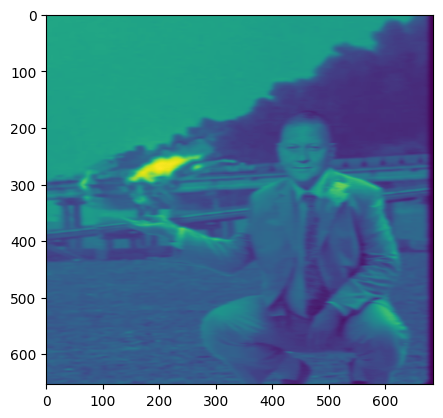

In [11]:
plt.imshow(gauss_img[:, :, 0, 0])

### Box filter ###

In [12]:
def box_filter_kernel(size: int):
    box_kernel = np.ones((size, size))/(size**2)
    return box_kernel[:, :, tf.newaxis, tf.newaxis]

In [13]:
box_filter_kernel = box_filter_kernel(25)
box_image = tf.nn.conv2d(img_tf[:, :, :, tf.newaxis], box_filter_kernel, strides=[1, 1, 1, 1], padding="SAME")

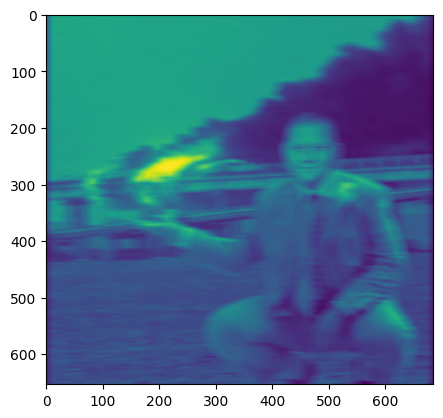

In [14]:
plt.imshow(box_image[:, :, 0, 0])

### Unsharp ###

In [15]:
def unsharp_kernel():
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    return kernel[:, :, tf.newaxis, tf.newaxis]

In [21]:
unsharp_filter_kernel = unsharp_kernel()
unsharp_image = tf.nn.conv2d(img_tf[:, :, :, tf.newaxis], unsharp_filter_kernel, strides=[1, 1, 1, 1], padding="SAME")

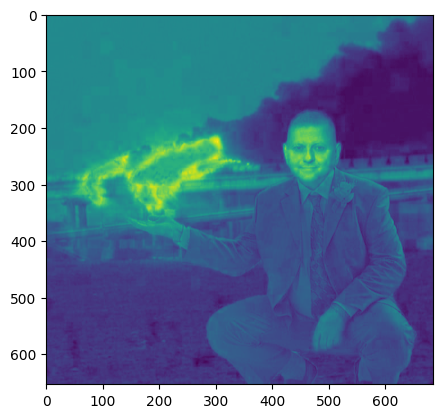

In [22]:
plt.imshow(unsharp_image[:, :, 0, 0])

### Min max ###

In [18]:
def min_max(image, channel=0):
    single_channel = image[:, :, channel]
    data_min = tf.math.reduce_min(image)
    data_max = tf.math.reduce_max(image)
    return (image[:, :, channel] - data_min)/(data_max - data_min)

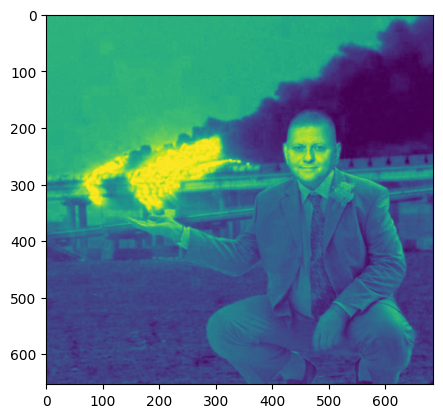

In [19]:
min_max_image = min_max(img_tf)
plt.imshow(min_max_image)

### Standardization   ###

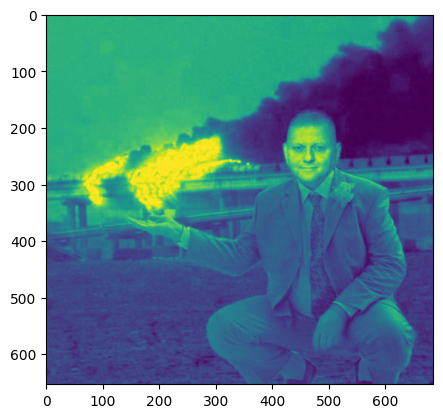

In [20]:
img_stand = tf.image.per_image_standardization(img_tf)
plt.imshow(img_stand[:, :, 0])